In [1]:
#CTA Public goods experiment

In [ ]:
suppressPackageStartupMessages({
library(MASS, quietly = TRUE)
library(stringi, quietly = TRUE)
library(wordcloud, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(tidyr, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(data.table, quietly = TRUE)
library(stargazer, quietly = TRUE)
library(quanteda, quietly = TRUE)
library(xlsx, quietly = TRUE)
library(stringr, quietly = TRUE)
library(xtable, quietly = TRUE)
    library(mfx, quietly = TRUE)
    library(forcats, quietly = TRUE)
    library(ggalt)
    library(stm)
    library(udpipe)
    library(BTM)
    library(quanteda)
    library(spacyr)
    })

In [4]:
path_data <- ""
df <- read.csv(paste(path_data,'tdm1011_metadata.csv',sep=''))

# Assign values to 'text', 'outcome', and 'metadata'
text <- df$strategy.description
outcome <- df$primed.for.intuition
metadata <- df[c('education','female','contribution','normalized.contribution')]


In [5]:
df$nsentence <- ifelse(is.na(text)==F,nsentence(text),NA)
df$nwords <- ifelse(is.na(text)==F,str_count(text, "\\w+"),NA)

Warning message in nsentence.character(text):
"nsentence() does not correctly count sentences in all lower-cased text"


In [6]:
mean(df$nsentence)
median(df$nsentence)
sd(df$nsentence)

[1] 1.004032

[1] 1

[1] 0.06350006

In [7]:
mean(df$nwords)
median(df$nwords)
sd(df$nwords)

[1] 20.78629

[1] 18

[1] 12.5559

In [8]:
nrow(df)

[1] 248

In [10]:
tdm_lemma <- read.csv(paste(path_data,'tdm_lemmatized.csv',sep=''))


In [11]:
toks_q <- tokens(tdm_lemma$text,
  remove_punct = TRUE, remove_numbers = TRUE
) %>%
  tokens_tolower()

In [12]:
as.data.frame.tokens <- function(x) {
  data.frame(
    doc_id = rep(names(x), lengths(x)),
#       doc_id = rep(lengths(x)),
    tokens = unlist(x, use.names = FALSE)
  )
}

In [13]:
set.seed(42)
model2 <- BTM(as.data.frame.tokens(toks_q), k = 4, beta = 0.01, iter = 100, trace = 10)

2024-03-27 14:41:42 Start Gibbs sampling iteration 1/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 11/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 21/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 31/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 41/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 51/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 61/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 71/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 81/100
2024-03-27 14:41:42 Start Gibbs sampling iteration 91/100


In [14]:
# Convert to dataframe
df_topic_probabilities <- data.frame(predict(model2, newdata = as.data.frame.tokens(toks_q)))

# Rename the columns
colnames(df_topic_probabilities) <- paste0("topic_", 1:ncol(df_topic_probabilities))

df_topic_probabilities$doc <- rownames(df_topic_probabilities)

# If you want 'doc' to be the first column
df_topic_probabilities <- df_topic_probabilities[, c(ncol(df_topic_probabilities), 1:(ncol(df_topic_probabilities)-1))]
df_topic_probabilities$doc <- as.numeric(gsub("text", "", df_topic_probabilities$doc))
df_topic_probabilities <- df_topic_probabilities[order(df_topic_probabilities$doc), ]
rownames(df_topic_probabilities) <- NULL

In [15]:
write.csv(df_topic_probabilities, 
          paste(path_data,"btm_tdm_topic_probabilities.csv",sep=''),
          row.names = FALSE)

In [16]:
# Get top words for each topic
top_words <- terms(model2, top_n = 5)

# Initialize an empty dataframe
df_top_words <- data.frame(matrix(ncol = length(top_words), nrow = 1))

# Fill the dataframe
for (i in 1:length(top_words)) {
  df_top_words[,i] <- paste(top_words[[i]]$token, collapse = ", ")
}

# Rename the columns
colnames(df_top_words) <- paste0("topic_", 1:ncol(df_top_words))


In [17]:
write.csv(df_top_words, 
          paste(path_data,"btm_tdm_top_words.csv",sep=''), 
          row.names = FALSE)

In [18]:
df_top_words

topic_1,topic_2,topic_3,topic_4
<chr>,<chr>,<chr>,<chr>
"contribute, cent, good, group, money","good, group, believe, like, decision","people, cent, contribute, group, want","contribute, people, feel, want, believe"


In [19]:
#stm

temp<-textProcessor(documents=tdm_lemma$text,metadata=tdm_lemma,stem = FALSE)
out <- prepDocuments(temp$documents, temp$vocab, temp$meta)


Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Creating Output... 
Removing 249 of 432 terms (249 of 1508 tokens) due to frequency 
Removing 4 Documents with No Words 
Your corpus now has 244 documents, 183 terms and 1259 tokens.

In [20]:
# help(textProcessor)

In [21]:
set.seed(42)
mod.out <- stm(out$documents, out$vocab, 4,seed=42,
prevalence=~treatment, data=out$meta,max.em.its = 1000)


Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	....
	 Recovering initialization...
 	.
Initialization complete.
..........................................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -4.961) 
..........................................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -4.781, relative change = 3.620e-02) 
..........................................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -4.708, relative change = 1.530e-02) 
........................................................................................

In [22]:
summary(mod.out)

A topic model with 4 topics, 244 documents and a 183 word dictionary.


Topic 1 Top Words:
 	 Highest Prob: want, choose, feel, give, fair, right, greedy 
 	 FREX: want, greedy, away, answer, help, player, sense 
 	 Lift: want, answer, away, communicate, daily, deal, enjoy 
 	 Score: want, experience, feel, greedy, fair, choose, right 
Topic 2 Top Words:
 	 Highest Prob: group, think, benefit, way, decide, thing, little 
 	 FREX: group, think, benefit, way, decide, bit, lose 
 	 Lift: leave, take, base, benefit, group, think, way 
 	 Score: group, benefit, rely, decide, think, way, bit 
Topic 3 Top Words:
 	 Highest Prob: people, good, like, hope, know, risk, try 
 	 FREX: like, life, gain, gamble, sure, good, involve 
 	 Lift: gain, gamble, sure, averse, certain, contributing, find 
 	 Score: people, good, instinct, like, know, hope, life 
Topic 4 Top Words:
 	 Highest Prob: contribute, money, cent, believe, figure, bonus, chance 
 	 FREX: contribute, cent, figure, bonus, chance, half, get 
 	 Lift: chance, half, allow, bible, cent, christian, consider 
 

In [23]:
stm_topic_proportions <- as.data.frame(mod.out$theta)
# Get the number of topics
num_topics <- ncol(stm_topic_proportions)

# Create the new column names
new_colnames <- paste0("topic_", 1:num_topics)

# Assign the new column names to the dataframe
colnames(stm_topic_proportions) <- new_colnames


In [24]:
stm_topic_proportions$treatment <- out$meta$treatment

In [25]:
write.csv(stm_topic_proportions, 
          paste(path_data,"stm_tdm_topic_probabilities.csv",sep=''),
          row.names = FALSE)

In [26]:
# Get the top 5 words for each topic
top_words <- labelTopics(mod.out, n=5)

# Convert the matrix to a dataframe
stm_top_words <- as.data.frame(t(top_words$prob))

# Convert the top words for each topic to a single string, separated by a comma
stm_top_words <- apply(stm_top_words, 2, paste, collapse = ", ")

# Convert the matrix back to a dataframe
stm_top_words <- as.data.frame(t(stm_top_words))

# Assign the new column names to the dataframe
colnames(stm_top_words) <- new_colnames

In [27]:
stm_top_words

topic_1,topic_2,topic_3,topic_4
<chr>,<chr>,<chr>,<chr>
"want, choose, feel, give, fair","group, think, benefit, way, decide","people, good, like, hope, know","contribute, money, cent, believe, figure"


In [28]:
write.csv(stm_top_words, 
          paste(path_data,"stm_tdm_top_words.csv",sep=''), 
          row.names = FALSE)

In [ ]:
# Make plots

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


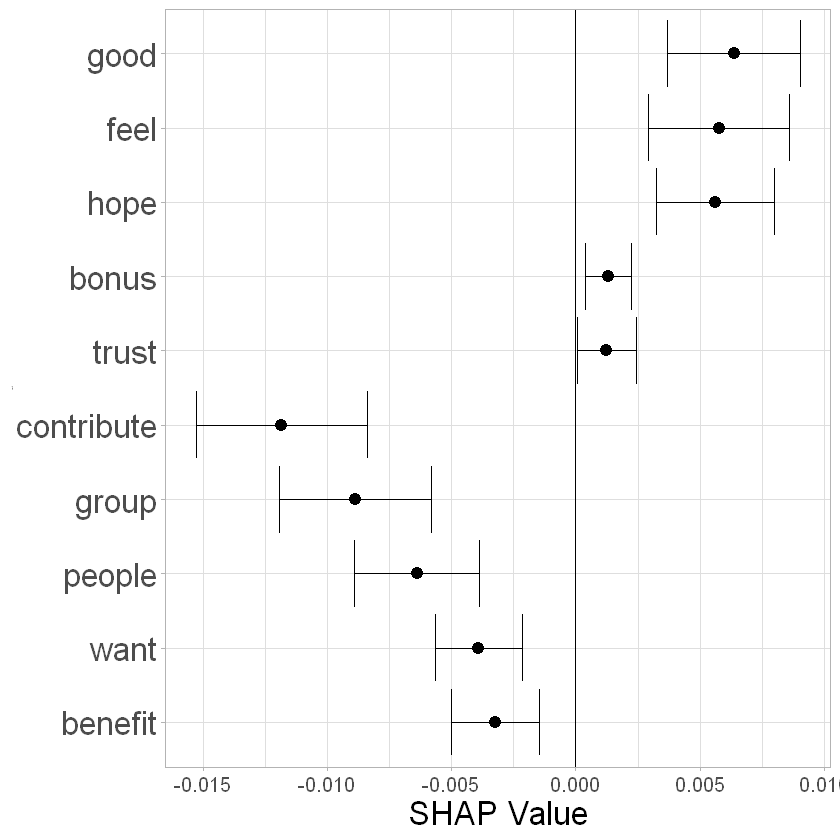

In [44]:
# load X_all
feature_imp <- read.csv("tdm_intuition_shap_bert_allwords_220324_train_lemma_shap_lemma.csv"
                          ,header = TRUE, sep = ",")

# compute mean and t-val for each word

words_shap <- data.frame(word=colnames(feature_imp))
words_shap$mean <- 0
words_shap$se <- 0
words_shap$t_val <- 0
words_shap$p_val <- 0


for (i in c(1:nrow(words_shap))){
    word_name <- words_shap$word[i]
    shap_col <- feature_imp[,word_name]
#     shap_col <- shap_col[which(shap_col!=0)]
    words_shap$mean[i] <- mean(shap_col)
#     words_shap$median[i] <- median(shap_col)
    words_shap$se[i] <- sd(shap_col)/sqrt(length(shap_col))
    words_shap$t_val[i] <- abs(words_shap$mean[i]/words_shap$se[i])
#     words_shap$t_val[i] <- abs(words_shap$mean[i]/(words_shap$sd[i]))
    words_shap$p_val[i] <- t.test(feature_imp[,word_name])$p.val
}
words_shap$mean_abs <- abs(words_shap$mean)
words_shap <- words_shap[order(-words_shap$mean_abs),]

n_words <- 5
# word_shap_tmp <- words_shap[which(words_shap$mean>0&words_shap$t_val>1.96),]
word_shap_tmp <- words_shap[which(words_shap$mean>0&words_shap$p_val<0.1),]
words_tmp <- word_shap_tmp[1:n_words,'word']
# words_tmp_corr <- word_shap_tmp[1:n_words,'word_corr']

# word_shap_tmp <- words_shap[which(words_shap$mean<0&words_shap$t_val>1.96),]
word_shap_tmp <- words_shap[which(words_shap$mean<0&words_shap$p_val<0.1),]
words_tmp <- c(words_tmp,word_shap_tmp[1:n_words,'word'])
# words_tmp_corr <-  c(words_tmp_corr,word_shap_tmp[1:n_words,'word_corr'])

shap_words_tmp <- feature_imp[,words_tmp]


# reshape as long datafile

index <- 1
for (i in colnames(shap_words_tmp)){
    n_obs <- nrow(shap_words_tmp)
    if(index==1){
        shap_words_tmp_reshape <- data.frame(shap=shap_words_tmp[,index],word=colnames(shap_words_tmp)[index])
    }else{
        tmp_reshape <- data.frame(shap=shap_words_tmp[,index],word=colnames(shap_words_tmp)[index])
        shap_words_tmp_reshape <- rbind(shap_words_tmp_reshape,tmp_reshape)
    }
    index <- index+1
}

# shap_words_tmp_reshape <- shap_words_tmp_reshape[which(shap_words_tmp_reshape$shap!=0),]
shap_words_tmp_reshape$word <- fct_rev(factor(shap_words_tmp_reshape$word , levels=colnames(shap_words_tmp)))

min.mean.sd.max <- function(x) {
  r <- c(t.test(x)$"conf.int"[1], t.test(x)$"conf.int"[1], 
         mean(x), t.test(x)$"conf.int"[2], 
         t.test(x)$"conf.int"[2])
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

ggplot(shap_words_tmp_reshape, aes(x = shap, y = word)) + 
  geom_vline(xintercept =0) + 
  theme_light() + 
  xlab("SHAP Value") +
  theme(axis.title.x = element_text(size = 20),
        axis.text.x = element_text(size = 12),
        axis.title.y = element_text(size =0),
        axis.text.y = element_text(size =20)) +
  stat_summary(fun.data = min.mean.sd.max, geom = "errorbar", size=0.5) +
  stat_summary(
    geom = "point",
    fun = "mean",
    col = "black",
    size = 3,
    shape = 21,
    fill = "black"
  )
